In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16


from tensorflow.keras.utils import to_categorical, model_to_dot


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Klasyfikacja śmieci

In [6]:
data_path = 'drive/MyDrive/input/garbage classification/Garbage classification'
categories = os.listdir(data_path)

In [7]:
print(categories)

['trash', 'cardboard', 'paper', 'metal', 'glass', 'plastic']


In [8]:
img_height, img_width = 128, 128
batch_size = 32

In [9]:
train_batches = ImageDataGenerator(
   rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
    validation_split=0.1)

train_batches = train_batches.flow_from_directory(
        directory=data_path, 
        target_size=(img_width,img_height), 
        classes=categories, 
        batch_size=batch_size,shuffle= True,seed= 1111, subset='training')

valid_batches = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.1)

valid_batches = valid_batches.flow_from_directory(
    directory=data_path, 
    target_size=(img_width,img_height), 
    classes=categories, batch_size=batch_size,shuffle= True,seed= 1111, subset='validation')

test_batches = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.1)

test_batches = test_batches.flow_from_directory(
    directory=data_path, 
    target_size=(img_width,img_height),
    classes=categories,
    batch_size=251,shuffle= False,subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


the numbers of images in trash class :  137
(384, 512, 3)


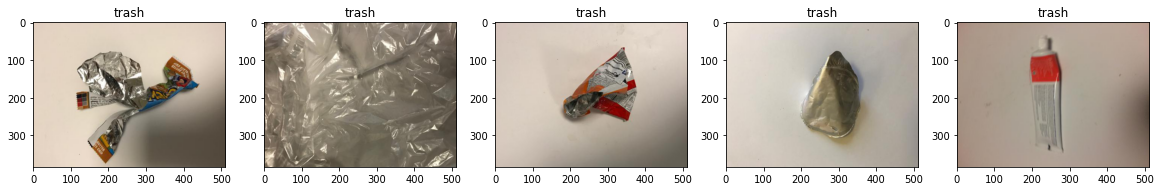

the numbers of images in cardboard class :  403
(384, 512, 3)


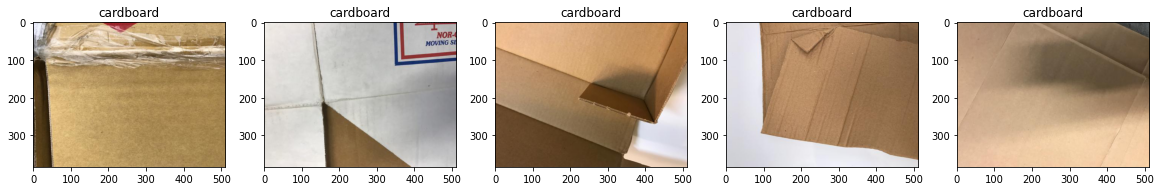

the numbers of images in paper class :  594
(384, 512, 3)


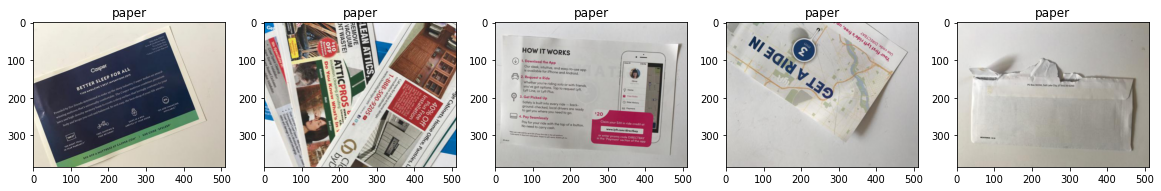

the numbers of images in metal class :  410
(384, 512, 3)


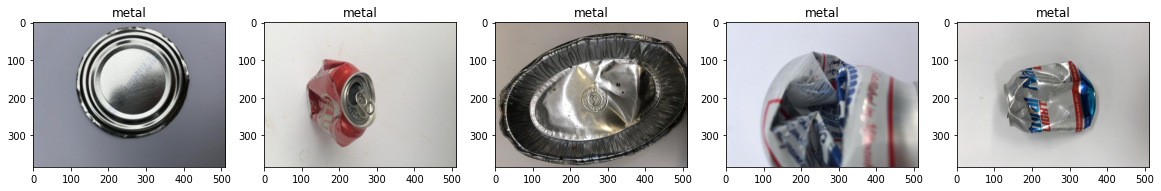

the numbers of images in glass class :  501
(384, 512, 3)


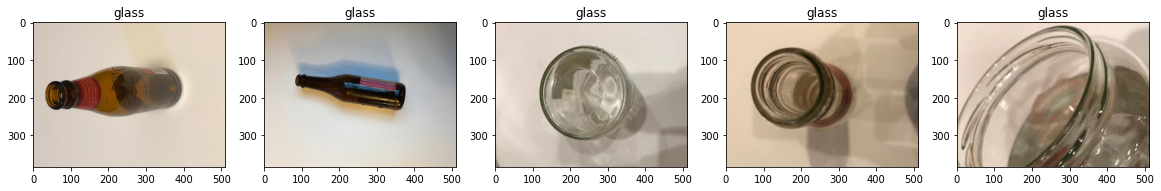

the numbers of images in plastic class :  482
(384, 512, 3)


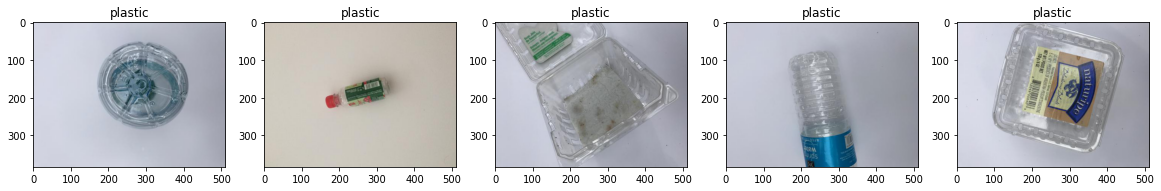

In [ ]:
for i in range(len(categories)):
    imageInfile=[]
    imageInfile=os.listdir(os.path.join(data_path,categories[i]))
    print( f"the numbers of images in {categories[i]} class : " , len(imageInfile))
    plt.figure(figsize=(20,20))
    for j in range(5):
        plt.subplot(1,5,j+1)
        image=plt.imread(os.path.join(os.path.join(data_path,categories[i]),imageInfile[j]))
        plt.title(categories[i])
        plt.imshow(image,cmap='gray')
    print(image.shape)
    plt.show()

## Podejscie transfer-learningu

In [65]:

base_model = VGG16(weights='imagenet',input_shape=(128,128,3), include_top=False)


In [66]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [67]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1)]

model = Sequential()

base_model.trainable=False

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(units=256, activation='relu'))  
model.add(BatchNormalization()) 
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))  
model.add(BatchNormalization()) 
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu'))  
model.add(BatchNormalization()) 
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

In [68]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [69]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
model_transfer = model.fit(train_batches, 
    epochs = 30,
    validation_data = valid_batches,
    callbacks = callbacks)

Epoch 1/30
72/72 [==============================] - 22s 283ms/step - loss: 1.7112 - accuracy: 0.3739 - val_loss: 1.5193 - val_accuracy: 0.4104
Epoch 2/30
72/72 [==============================] - 20s 279ms/step - loss: 1.2743 - accuracy: 0.5286 - val_loss: 1.2587 - val_accuracy: 0.5618
Epoch 3/30
72/72 [==============================] - 20s 278ms/step - loss: 1.1687 - accuracy: 0.5764 - val_loss: 1.1000 - val_accuracy: 0.6016
Epoch 4/30
72/72 [==============================] - 21s 291ms/step - loss: 1.0828 - accuracy: 0.5931 - val_loss: 0.9541 - val_accuracy: 0.6295
Epoch 5/30
72/72 [==============================] - 20s 277ms/step - loss: 1.0570 - accuracy: 0.6011 - val_loss: 0.9544 - val_accuracy: 0.6414
Epoch 6/30
72/72 [==============================] - 20s 277ms/step - loss: 1.0004 - accuracy: 0.6318 - val_loss: 0.9224 - val_accuracy: 0.6733
Epoch 7/30
72/72 [==============================] - 20s 280ms/step - loss: 0.9398 - accuracy: 0.6516 - val_loss: 0.8080 - val_accuracy: 0.7012

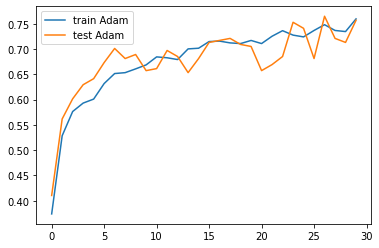

In [71]:


plt.plot(model.history.history['accuracy'], label = "train Adam")
plt.plot(model.history.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()


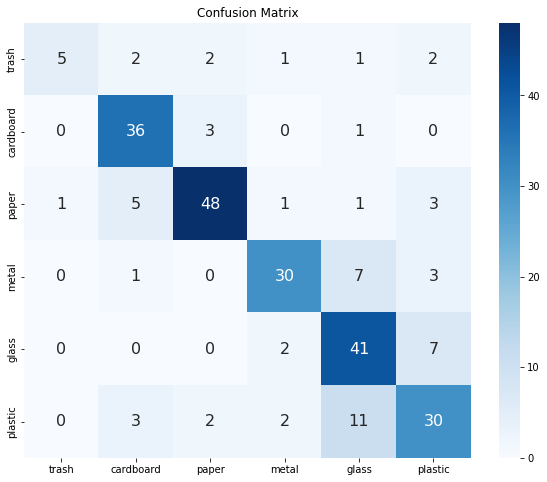

In [72]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix


Y_pred = model.predict(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, categories, categories)
fig, ax = plt.subplots(figsize=(10,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [74]:
print(classification_report(test_batches.classes, y_pred, target_names=categories))

['trash', 'cardboard', 'paper', 'metal', 'glass', 'plastic']
              precision    recall  f1-score   support

       trash       0.83      0.38      0.53        13
   cardboard       0.77      0.90      0.83        40
       paper       0.87      0.81      0.84        59
       metal       0.83      0.73      0.78        41
       glass       0.66      0.82      0.73        50
     plastic       0.67      0.62      0.65        48

    accuracy                           0.76       251
   macro avg       0.77      0.71      0.73       251
weighted avg       0.77      0.76      0.75       251



### Klasyfikacja dla wlasnych zdjec

In [76]:
from tensorflow.keras.applications.vgg16 import preprocess_input

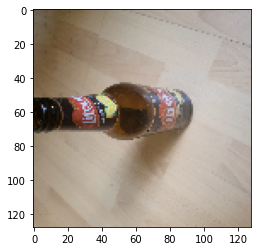

In [77]:
img_path = "./glass.jpg"
img = image.load_img(img_path, target_size=(128, 128))

plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)


In [81]:
prediction = model.predict(img_preprocessed)
print(categories[np.argmax(prediction)])

glass


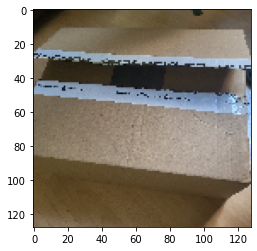

In [82]:
img_path = "./cardboard.jpg"
img = image.load_img(img_path, target_size=(128, 128))

plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)


In [83]:
prediction = model.predict(img_preprocessed)
prediction = model.predict(img_preprocessed)
print(categories[np.argmax(prediction)])

cardboard


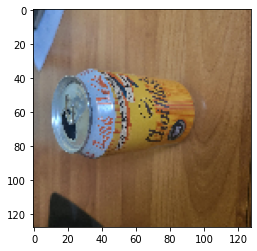

In [84]:
img_path = "./metal.jpg"
img = image.load_img(img_path, target_size=(128, 128))

plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)


In [85]:
prediction = model.predict(img_preprocessed)
prediction = model.predict(img_preprocessed)
print(categories[np.argmax(prediction)])

metal


## Siec konwolucyjna

In [ ]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)]

model = Sequential()

model.add(Conv2D(32, (3, 3),activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(6,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 124, 124, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                      

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_cnn = model.fit(train_batches, 
    epochs = 25,
    validation_data = valid_batches,
    callbacks = callbacks)

Epoch 1/25
72/72 [==============================] - 775s 11s/step - loss: 1.6775 - accuracy: 0.4091 - val_loss: 3.3276 - val_accuracy: 0.1912
Epoch 2/25
72/72 [==============================] - 20s 281ms/step - loss: 1.3529 - accuracy: 0.5062 - val_loss: 2.4141 - val_accuracy: 0.3108
Epoch 3/25
72/72 [==============================] - 20s 280ms/step - loss: 1.1937 - accuracy: 0.5483 - val_loss: 2.2805 - val_accuracy: 0.2191
Epoch 4/25
72/72 [==============================] - 20s 277ms/step - loss: 1.1275 - accuracy: 0.5804 - val_loss: 2.2928 - val_accuracy: 0.2590
Epoch 5/25
72/72 [==============================] - 20s 278ms/step - loss: 1.0623 - accuracy: 0.6129 - val_loss: 2.4877 - val_accuracy: 0.2789
Epoch 6/25
72/72 [==============================] - 20s 277ms/step - loss: 0.9867 - accuracy: 0.6366 - val_loss: 2.9347 - val_accuracy: 0.2908
Epoch 7/25
72/72 [==============================] - 20s 278ms/step - loss: 0.9916 - accuracy: 0.6318 - val_loss: 2.0144 - val_accuracy: 0.2789


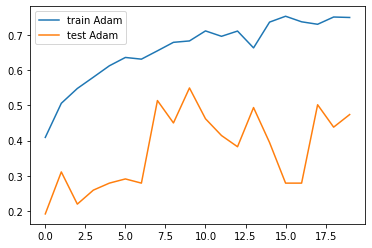

In [ ]:
plt.plot(model.history.history['accuracy'], label = "train Adam")
plt.plot(model.history.history['val_accuracy'], label = "test Adam")
plt.legend()
plt.show()


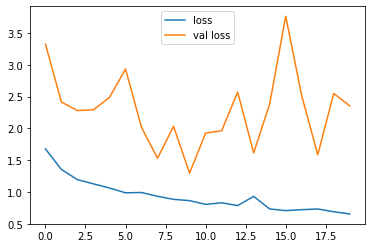

In [ ]:
plt.plot(model.history.history['loss'], label = "loss")
plt.plot(model.history.history['val_loss'], label = "val loss")
plt.legend()
plt.show()

## Metoda _płytka_ - SVM (flatten)

In [29]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [30]:
flat_data_arr=[]
target_arr=[]

for i in categories:    
    print(f'loading... category : {i}')
    path=os.path.join(data_path,i)   
    for img in os.listdir(path): 
        img_array= imread(os.path.join(path,img))
        img_resized= resize(img_array, (50,50,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
x=df.iloc[:,:-1] 
y=df.iloc[:,-1]


loading... category : trash
loaded category:trash successfully
loading... category : cardboard
loaded category:cardboard successfully
loading... category : paper
loaded category:paper successfully
loading... category : metal
loaded category:metal successfully
loading... category : glass
loaded category:glass successfully
loading... category : plastic
loaded category:plastic successfully


In [31]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print(x_train.shape)

(2021, 7500)


In [33]:
os.path.exists('finalized_model.sav')

True

In [34]:
model = model.fit(x_train, y_train) if not os.path.exists('finalized_model.sav') \
                        else pickle.load(open('finalized_model.sav', 'rb'))

In [38]:
print(y_test,test_batches.class_indices.keys())

179     1
1821    4
647     2
544     2
2330    5
       ..
2052    5
1228    3
1294    3
37      0
613     2
Name: Target, Length: 506, dtype: int64 dict_keys(['trash', 'cardboard', 'paper', 'metal', 'glass', 'plastic'])


In [47]:
print(classification_report(y_test, model.predict(x_test), target_names = categories))

              precision    recall  f1-score   support

       trash       0.05      0.19      0.08        27
   cardboard       0.88      0.84      0.86        81
       paper       0.00      0.00      0.00       119
       metal       0.82      0.83      0.82        82
       glass       0.01      0.01      0.01       100
     plastic       0.64      0.79      0.71        97

    accuracy                           0.43       506
   macro avg       0.40      0.44      0.41       506
weighted avg       0.40      0.43      0.41       506



In [50]:
from sklearn.metrics import accuracy_score
print(accuracy_score(model.predict(x_test),y_test))

0.43280632411067194


In [40]:
model.best_params_


{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [41]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Metoda _płytka_ -- Kmeans

In [51]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import matplotlib.pyplot as plt

In [52]:
flat_data_arr=[]
target_arr=[]

for i in categories:    
    print(f'loading... category : {i}')
    path=os.path.join(data_path,i)   
    for img in os.listdir(path): 
        img_array= imread(os.path.join(path,img))
        img_resized= resize(img_array, (50,50,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)/255
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
x=df.iloc[:,:-1] 
y=df.iloc[:,-1]

loading... category : trash
loaded category:trash successfully
loading... category : cardboard
loaded category:cardboard successfully
loading... category : paper
loaded category:paper successfully
loading... category : metal
loaded category:metal successfully
loading... category : glass
loaded category:glass successfully
loading... category : plastic
loaded category:plastic successfully


In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=1)
clusters = kmeans.fit_predict(X=x)
kmeans.cluster_centers_.shape


(6, 7500)

In [56]:
def get_reference_dict(clusters,data_label):
    reference_label = {}
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [57]:
reference_labels = get_reference_dict(clusters,y)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,y))

0.36367233874159083


## Metoda _płytka_ + feature selection z CNN 

In [58]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, f1_score


In [59]:
model = VGG16(weights='imagenet',input_shape=(128,128,3), include_top=False)

In [60]:
features = []
img_names = []
for i in categories:    
    print(f'loading... category : {i}')
    path=os.path.join(data_path,i)   
    for img in os.listdir(path):
        img=image.load_img(os.path.join(path,img),target_size=(128,128))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_names.append(categories.index(i)) 
    print(f'loaded category:{i} successfully')

loading... category : trash
loaded category:trash successfully
loading... category : cardboard
loaded category:cardboard successfully
loading... category : paper
loaded category:paper successfully
loading... category : metal
loaded category:metal successfully
loading... category : glass
loaded category:glass successfully
loading... category : plastic
loaded category:plastic successfully


In [61]:
features=np.array(features)
target=np.array(img_names)
df=pd.DataFrame(features)
df['Target']=target
x=df.iloc[:,:-1] 
y=df.iloc[:,-1]

In [62]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=1)
clusters = kmeans.fit_predict(X=x)
kmeans.cluster_centers_.shape


(6, 8192)

In [63]:
reference_labels = get_reference_dict(clusters,y)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,y))

0.48041155520379897


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

# *Podsumowanie*
Najlepiej sprawdziła się metoda transfer learningu - tu nie ma niespodzianki. Model ktory byl trenowany pare tygodni na imagenecie calkiem niezle radzi sobie z domeną problemu w tym datasecie


Niespodzianką jest wynik płytkiego uczenia. Maszyna wektorów nośnych (chociaż liczyła się całą noc dla prostego flattena) ma accuracy rzędu 60% na trainie oraz 40% na tescie

Oprócz tego została sprawdzona własna sieć konwolucyjna oraz płytki KMeans. Sieć odniosła accuracy rzędu 50% a Kmeans rzędu 40 po wyekstraktowaniu featurów już po VGG16. Kmeans jest jednak oparte na dystansie który jest mocno zakrzywiony przez wielowymiarowość.